<a href="https://colab.research.google.com/github/bharath7896/GOOGLE-QUESTION-ANSWERING/blob/master/GoogleQ_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> QUESTION-ANSWER INTENT RANKING BY KEYWORD FILTERING AND INTENT UNDERSTANDING

## In the below Dataset we are given various queries and their corresponding categories with the probability of occurance of the query to the corresponding intent category
## We are also provided with the answer and other parameters which are useful in classifying the whether the answer is more reliable or not.

* Generally we understand a query or a setence by breaking down the structural phrases and then understanding the semantics
* for a query to be more specific the 'question-word','POS sequence' and 'entity' are three core parameters to understand its intent more spcifically 


1. We are going to extract the structural differences and the semantic differences seperately and then combine them to get the perfect order of the clasification result 
2. We are going to consider the key words i,e q-word, verbs , entities of properly framed questions
3. for improper structural sentences and queries with non-q words we are going to convert them into a proper question and then we are going to apply the features on those sentences.
4. Thus for every well framed and well structured sentence we are going to rank the categories based on how frequently the keywords have occured in the corresponding categories and at which position of the sentence and how the intent filters that we are going to apply are matching the inferences.

In [1]:
%%capture
!pip install -q flair
!pip install -q transformers
!pip install -q sentence_transformers
!pip install -q simple_transformers
#! pip install -q rasa_nlu
#!python -m rasa_nlu.server sklearn_crfsuite
#! pip install -q rasa_nlu[spacy]
#!python -m spacy link en_core_web_md
!pip install sense2vec
!spacy.download('en_core_web_md')
# restart the runtime after running this cell

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir  ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c google-quest-challenge

In [ ]:
!unzip train.csv.zip
!rm train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [1]:
%matplotlib inline
# importing the necessary libraries
import pandas as pd 
import numpy as np
#misc
import gc
import time
import warnings
#stats
from scipy import sparse
import scipy.stats as ss
#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
#nlp
import string
import re    #for regex
import nltk
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import train_test_split

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")
lem = WordNetLemmatizer()
#importing functions from functions notebook
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os

In [2]:
import torch
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten, Masking
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
import scipy as sp
import networkx as nx
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder

In [3]:
# loading train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
# train data columns and shape
print(train.shape)
train.columns

(6079, 41)


Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfa

In [ ]:
print(test.shape)
test.columns

(476, 11)


Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host'],
      dtype='object')

In [ ]:
# preparing a detailed summary of reports of the above data
# import pandas_profiling
# report = pandas_profiling.ProfileReport(train)
# report

In [ ]:
# combining the above text to find the most common words
text = " ".join(question_body for question_body in train.question_body)
text1 = " ".join(question_title for question_title in train.question_title )
text2 = " ".join(answer for answer in train.answer)
print ("There are {} words in the combination of all questions.".format(len(text)))


There are 5074508 words in the combination of all questions.


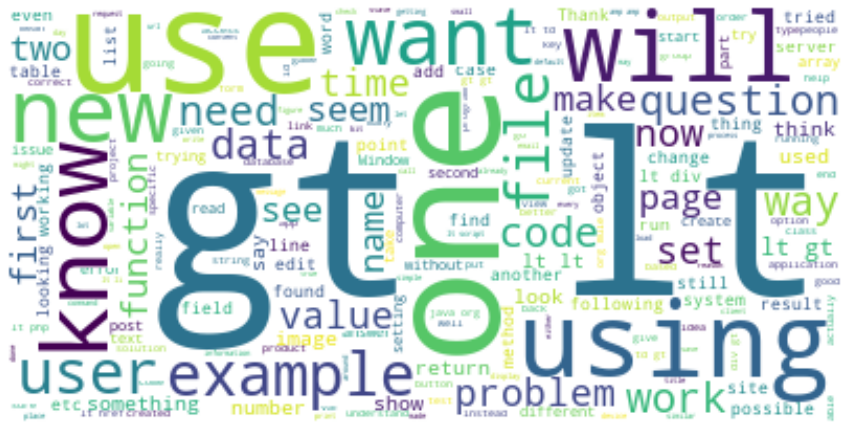

In [ ]:
# @title Getting wordcloud of the text in Data
%matplotlib inline
stopwords = set(STOPWORDS)
# Generate a word cloud image
def cloudgen(tx):
  '''prints wordcloud of the given input text'''
  wordcloud = WordCloud(background_color="white").generate(tx)
  # Display the generated image:
  # the matplotlib way:
  plt.figure(figsize=(15,8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
cloudgen(text)  

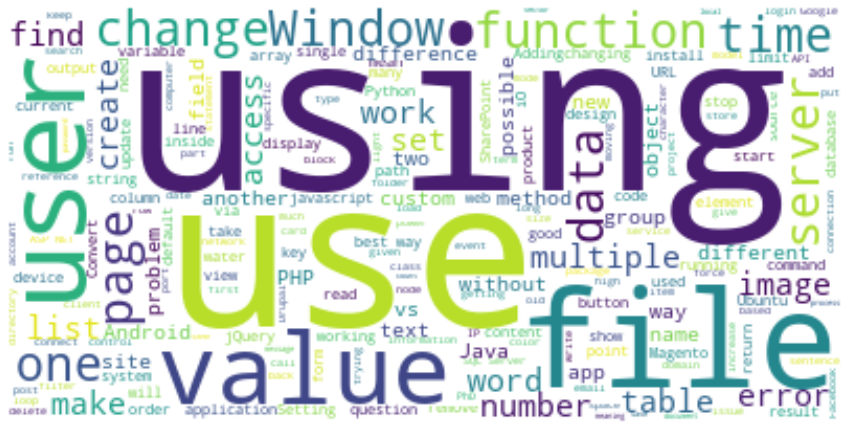

In [ ]:
#question title
cloudgen(text1)

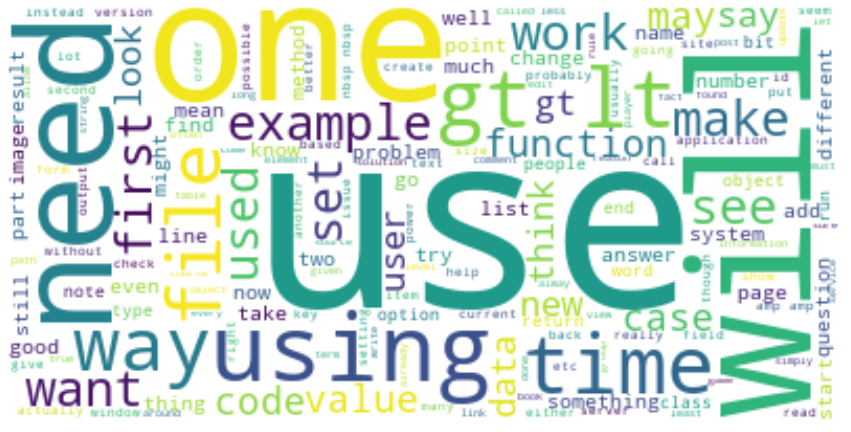

In [ ]:
# answer text
cloudgen(text2)

In [ ]:
train.category.value_counts()

TECHNOLOGY       2441
STACKOVERFLOW    1253
CULTURE           963
SCIENCE           713
LIFE_ARTS         709
Name: category, dtype: int64

# DATA PREPROCESSING:

In [4]:
!python -m spacy download "en_core_web_md"

     |████████████████████████████████| 45.7 MB 26 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [5]:
import spacy

def lemmatization(texts, allowed_postags=['PROPN','ADV','ADJ','VERB','NOUN'],nlp = spacy.load('en_core_web_md')):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(sent) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [6]:
#  Preprocessing and filtering the text
import re
from nltk.corpus import stopwords

def textract(phrase):
  '''removing special charecters from the text'''
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  phrase = re.sub("doesn't", "does not", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  phrase = re.sub(r"/" , "or" , phrase)
  phrase = re.sub('[^A-Za-z.,?]+', ' ', phrase).lower()
  phrase = ' '.join(x for x in phrase.split() if x not in ['a','an','the'])
  return phrase

In [52]:
train_qt = train['question_title'].map(str).apply(lambda x : textract(x))
train_qb = train['question_body'].map(str).apply(lambda x : textract(x))
train_ans = train['answer'].map(str).apply(lambda x : textract(x))

In [8]:
# @title preprocessing the test text data
test_qt = test['question_title'].map(str).apply(lambda x : textract(x))
test_qb = test['question_body'].map(str).apply(lambda x : textract(x))
test_ans = test['answer'].map(str).apply(lambda x : textract(x))

In [9]:
# @title Tfidf of the text features and extracting most common appeared words
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10, analyzer='word')
body_tfidf = vectorizer.fit_transform(train_qb)
print("Shape of matrix after one hot encodig ",body_tfidf.shape)

Shape of matrix after one hot encodig  (6079, 4210)


In [16]:
train_qb.values[1].replace('.',' [SEP]').replace(',',' [SEP]')

'i am trying to understand what kinds of places spam values on p refer to in th edition main book for shadowrun [SEP] per p  [SEP] sprawl is plex [SEP] plex is metropolitan complex [SEP] short for metroplex  [SEP] per google metroplex is very large metropolitan area [SEP] especially one that is aggregation of two or more cities  [SEP] city downtown and sprawl downtown would tend to have similar densities [SEP] but for some reason sprawl which includes suburbs? has higher spam zone noise rating p  [SEP] similarly [SEP] i would think of downtown as being more dense and noisy e [SEP]g [SEP] office buildings and street vendors than commercial district [SEP] e [SEP]g [SEP] outdoor mall [SEP] noise ratings make me think that i am thinking about this incorrectly [SEP] what is better way of thinking of them?'

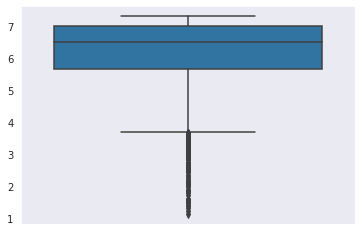

In [10]:
%matplotlib inline
# selecting the high distribution idf regions
import seaborn as sns
vdf =  vectorizer.idf_
sns.boxplot(y=vdf)

In [53]:
# @title Dividing questions falling under respective categories
qtchc = train.question_title[train['question_type_choice']==1]
qtops = train.question_title[train['question_opinion_seeking']==1]
qtcmp = train.question_title[train['question_type_compare']==1]
qtcon = train.question_title[train['question_type_consequence']==1]
qtdef = train.question_title[train['question_type_definition']==1]
qtent = train.question_title[train['question_type_entity']==1]
qtins = train.question_title[train['question_type_instructions']==1]
qtpro = train.question_title[train['question_type_procedure']==1]
qtexp = train.question_title[train['question_type_reason_explanation']==1]

In [12]:
# @title index values of categorical entities
idchc = [idx1 for idx1,val1 in enumerate(train.question_title[train['question_type_choice']==1])]
idops = [idx2 for idx2,val2 in enumerate(train.question_title[train['question_opinion_seeking']==1])]
idcmp = [idx3 for idx3,val3 in enumerate(train.question_title[train['question_type_compare']==1])]
idcon = [idx4 for idx4,val4 in enumerate(train.question_title[train['question_type_consequence']==1])]
iddef = [idx5 for idx5,val5 in enumerate(train.question_title[train['question_type_definition']==1])]
ident = [idx6 for idx6,val6 in enumerate(train.question_title[train['question_type_entity']==1])]
idins = [idx7 for idx7,val7 in enumerate(train.question_title[train['question_type_instructions']==1])]
idpro = [idx8 for idx8,val8 in enumerate(train.question_title[train['question_type_procedure']==1])]
idexp = [idx9 for idx9,val9 in enumerate(train.question_title[train['question_type_reason_explanation']==1])]

In [13]:
# @title class labels of the respective categories
y_chc = train.iloc[idchc,21:31]
y_ops = train.iloc[idops,21:31]
y_cmp = train.iloc[idcmp,21:31]
y_con = train.iloc[idcon,21:31]
y_def = train.iloc[iddef,21:31]
y_ent = train.iloc[ident,21:31]
y_ins = train.iloc[idins,21:31]
y_pro = train.iloc[idpro,21:31]
y_exp = train.iloc[idexp,21:31]
Y_train = train.iloc[:,21:31]

In [14]:
# @title questions body under respective categories categories
qbchc = train.question_body[train['question_type_choice']==1]
qbops = train.question_body[train['question_opinion_seeking']==1]
qbcmp = train.question_body[train['question_type_compare']==1]
qbcon = train.question_body[train['question_type_consequence']==1]
qbdef = train.question_body[train['question_type_definition']==1]
qbent = train.question_body[train['question_type_entity']==1]
qbins = train.question_body[train['question_type_instructions']==1]
qbpro = train.question_body[train['question_type_procedure']==1]
qbexp = train.question_body[train['question_type_reason_explanation']==1]

In [15]:
# @title Answer under categories 
achc = train.answer[train['question_type_choice']==1].apply(lambda x : textract(x))
aops = train.answer[train['question_opinion_seeking']==1].apply(lambda x : textract(x))
acmp = train.answer[train['question_type_compare']==1].apply(lambda x : textract(x))
acon = train.answer[train['question_type_consequence']==1].apply(lambda x : textract(x))
adef = train.answer[train['question_type_definition']==1].apply(lambda x : textract(x))
aent = train.answer[train['question_type_entity']==1].apply(lambda x : textract(x))
ains = train.answer[train['question_type_instructions']==1].apply(lambda x : textract(x))
apro = train.answer[train['question_type_procedure']==1].apply(lambda x : textract(x))
aexp = train.answer[train['question_type_reason_explanation']==1].apply(lambda x : textract(x))

# FEATURE ENGINEERING

In [16]:
# @title question-set
s = {'what','how','when','where',
     'why','is','can','do',
     'will','if','shall'}

In [17]:
# @title (Feature) Converting unstructured questions to proper question format 
def nq_q(nq):
    '''converting non question text to question format'''
    nq = pd.Series(nq)
    for txt in nq:
        rst = txt.split()
        doc = nlp(txt)
        for i,token in tqdm(enumerate(doc)):
            if token.text==rst[0] and token.pos_=='NOUN':  # adding what is/ what if to sentence starting with noun
                nq = nq.replace(text,'what'.join(text))
            elif token.text==rst[0] and token.pos_ =='VERB':
                nq = nq.replace(text,'how'.join(text))
            elif token.text==rst[0] and token.pos_ =='ADJ':
                nq = nq.replace(text,'is'.join(text))
    return nq

In [19]:
test_qt.values[15]

'brainf ck ish compiler in c'

In [18]:
# @title (Feature) questions starting from a distinct q-word from the above set

def qstart(qt):
    at = qt
    (what,how,when,where,why,Is,can,do,will,If,should,does,are,nonq) = ([] for _ in range(14))
    for i,qs in tqdm(enumerate(qt)):
        qn = qs.lower().split() 
        if qn[0].lower()=='what' and qn[-1][-1]=='?':
            what.append(qn[1])
            at.values[i]=at.values[i].replace(at.values[i],'what')
        elif qn[0].lower()=='how' and qn[-1][-1]=='?':
            how.append(qn[1])
            at.values[i]=at.values[i].replace(at.values[i],'how')
        elif qn[0].lower()=='when' and qn[-1][-1]=='?':
            when.append(qn[1])
            at.values[i]=at.values[i].replace(at.values[i],'when')
        elif qn[0].lower()=='where' and qn[-1][-1]=='?':
            where.append(qn[1])
            at.values[i]=at.values[i].replace(at.values[i],'where')
        elif qn[0].lower()=='why' and qn[-1][-1]=='?':
            why.append(qn[1])
            at.values[i]=at.values[i].replace(at.values[i],'why')
        elif qn[0].lower()=='is' and qn[-1][-1]=='?':
            Is.append(qn[1])
            at.values[i]=at.values[i].replace(at.values[i],'is')
        elif qn[0].lower()=='can' and qn[-1][-1]=='?':
            can.append(qn[1])
            at.values[i]=at.values[i].replace(at.values[i],'can')
        elif qn[0].lower()=='do' and qn[-1][-1]=='?':
            do.append(qn[1])
            at.values[i]=at.values[i].replace(at.values[i],'do')
        elif qn[0].lower()=='will' and qn[-1][-1]=='?':
            will.append(qn[1])
            at.values[i]=at.values[i].replace(at.values[i],'will')
        elif qn[0].lower()=='if' and qn[-1][-1]=='?':
            If.append(qn[1])
            
        else:
            nonq.append(qs)
            at.values[i]=at.values[i].replace(at.values[i],'nonq')
    dc = {'what':len(what)/len(qt),'when':len(when)/len(qt),'why':len(why)/len(qt),'where':len(where)/len(qt),
          'how':len(how)/len(qt),'is':len(Is)/len(qt),'do':len(do)/len(qt),'can':len(can)/len(qt),'will':len(will)/len(qt),
          'if':len(If)/len(qt),'nonq':len(nonq)/len(qt)}
    qt = qt.replace(dc)
    return (dc,at)



In [19]:
# @title (Feature) pos tagging using spacy

def pos_tag(sent):
    a = [];
    txt = nlp(sent)
    for token in txt:
        a.append(token.pos_)
    return a

ps = {'VERB','PRON','DET','ADV'}


In [20]:
# @title (Feature) Keywords extraction  i,e 'q-word'(Pron or verb) + verb + noun
from tqdm import tqdm
nlp = spacy.load('en_core_web_md')
def xscore(text):
    res = []
    doc = nlp(text.lower())
    for i,token in tqdm(enumerate(doc)):
        if token.pos_ in ps and token.text in s :
            res.append(token.text)
            return ' '.join(kw for kw in res)
        else :
            return text.lower()

In [23]:
%%time
print(test_qt.values[14])
print(xscore(test_qt.values[14]))

is there scalatest mechanism similar to testng dependsonmethods annotation


0it [00:00, ?it/s]

is there scalatest mechanism similar to testng dependsonmethods annotation
CPU times: user 23.7 ms, sys: 1.99 ms, total: 25.7 ms
Wall time: 36.2 ms


In [24]:
test_qb.values[0].split('.')

['i see questionsorinformation online about how to get rid of corpses but i am not sure what consequences to having them lying around are',
 ' i know that i can use morgue to store them and that they will eventually be taken away in hearse',
 ' however, i have always just left them lying around',
 ' this does not seem to have any obvious consequences',
 ' do they upset prisoners or staff e',
 'g',
 ' increasing danger level beyond what death normally does ? make them sick? slow down pathing? is this something that is not implemented yet or is leaving dead bodies all over place meant to be completely fine? wiki is pages for death and morgue don not shed any light on this',
 ' all i am finding is how of getting rid of corpsesorglitches related to it but not why it matters in first place',
 ' all i have seen that is related is that apparently prisoners can loot guard corpses for keys, but there is no obvious consequences for prisoner corpses which are what i tend to end up with',
 ' so wh

In [25]:
Y_train.values[0]

array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

##ATTENTION USING D2L

In [21]:
!pip install mxnet -q gluon
!pip install -q d2l

In [22]:
from d2l import mxnet as d2l
import mxnet as mx
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn

npx.set_np()

In [23]:
def mlp(num_hiddens, flatten):
    net = nn.Sequential()
    net.add(nn.Dropout(0.2))
    net.add(nn.Dense(num_hiddens, activation='relu', flatten=flatten))
    net.add(nn.Dropout(0.2))
    net.add(nn.Dense(num_hiddens, activation='relu', flatten=flatten))
    return net

In [24]:
class Attend(nn.Block):
    def __init__(self, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_hiddens=num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (b`atch_size`, no. of words in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of words in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of words in sequence A,
        # no. of words in sequence B)
        e = npx.batch_dot(f_A, f_B, transpose_b=True)
        # Shape of `beta`: (`batch_size`, no. of words in sequence A,
        # `embed_size`), where sequence B is softly aligned with each word
        # (axis 1 of `beta`) in sequence A
        beta = npx.batch_dot(npx.softmax(e), B)
        # Shape of `alpha`: (`batch_size`, no. of words in sequence B,
        # `embed_size`), where sequence A is softly aligned with each word
        # (axis 1 of `alpha`) in sequence B
        alpha = npx.batch_dot(npx.softmax(e.transpose(0, 2, 1)), A)
        return beta, alpha



In [25]:
class Compare(nn.Block):
    def __init__(self, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_hiddens=num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(np.concatenate([A, beta], axis=2))
        V_B = self.g(np.concatenate([B, alpha], axis=2))
        return V_A, V_B

In [26]:
class Aggregate(nn.Block):
    def __init__(self, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_hiddens=num_hiddens, flatten=True)
        self.h.add(nn.Dense(num_outputs))

    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(axis=1)
        V_B = V_B.sum(axis=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.h(np.concatenate([V_A, V_B], axis=1))
        return Y_hat

In [27]:
class DecomposableAttention(nn.Block):
    def __init__(self, vocab, embed_size, num_hiddens, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_hiddens)
        self.compare = Compare(num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_hiddens, 3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

In [33]:
list(train_qb.head(2))

['after playing around with macro photography on cheap read reversed lens, rev. lens mounted on straight lens, passive extension tubes , i would like to get further with this. problems with techniques i used is that focus is manual and aperture control is problematic at best. this limited my setup to still subjects read dead insects now, as spring is approaching, i want to be able to shoot live insects. i believe that for this, autofocus and settable aperture will be of great help. so, one obvious but expensive option is macro lens say, ef mm macro however, i am not really interested in yet another prime lens. alternative is electrical extension tubes. except for maximum focusing distance, what am i losing when using tubes coupled with fine lens, say ef or . instead of macro lens?',
 'i am trying to understand what kinds of places spam values on p refer to in th edition main book for shadowrun. per p , sprawl is plex, plex is metropolitan complex, short for metroplex . per google metro

In [ ]:
#@title (Feature) LDA
import gensim
from nltk.corpus import stopwords
from gensim import corpora
from gensim.corpora import *
from pprint import *
from gensim.models import *

ldata = lemmatization(train_qb)
dl = corpora.Dictionary(ldata)
#dictionary = corpora.Dictionary(list(df1.title.apply(lambda x : clean_text(x))))
# Build the LDA model
corpus = [dl.doc2bow(text) for text in ldata]
#lda_model = gensim.models.LdaMulticore(desc_tfidf.toarray(),num_topics=len(categs.level1_categories),id2word=dl,passes=4,workers=4)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dl,
                                           num_topics=14, 
                                           random_state=10,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)



pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Build the LSI model
lsi_model = LsiModel(corpus=corpus, num_topics=5, id2word=dl)
pprint(lsi_model.print_topics())
doc_lsi = lsi_model[corpus]

In [ ]:
# visualise lda and its metrics : https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling
   # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=ldata, dictionary=dl, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi)

In [ ]:
from gensim.models import *
# visualise lda and its metrics : https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=ldata, dictionary=dl, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# mallet model
!wget --header="Host: mallet.cs.umass.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.106 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" "http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip" -c -O 'mallet-2.0.8.zip'
!unzip -q mallet-2.0.8.zip

In [ ]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=11, id2word=dl)

In [ ]:
def coc_topic(txts):
  bow = dl.doc2bow(txts.strip('.').split())
  ltopics = lda_model.get_document_topics(bow,minimum_probability=0.000000001)
  a,b = map(list,zip(*ltopics))
  return np.array(b)
  

In [ ]:
%%time
tr_title_topics = train_qt.map(coc_topic)
tr_body_topics = train_qb.map(coc_topic)
tr_ans_topicis = train_ans.map(coc_topic)

In [ ]:
%%time
ts_title_topics = test_qt.map(coc_topic)
ts_body_topics = test_qb.map(coc_topic)
ts_ans_topics = test_ans.map(coc_topic)

In [ ]:
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=ldata, dictionary=dl, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dl)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dl, corpus=corpus, texts=ldata, start=2, limit=62, step=6)


In [ ]:
limit=62; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

In [ ]:
!pip install -q pyLDAvis
import pyLDAvis
from pyLDAvis.gensim import *
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=lda_model,corpus=corpus,dictionary=dl,mds='mmds')
vis

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [29]:
# @title (Feature) whether a properly framed question or not
def notq(qn):
    qsn = qn.lower().split()
    if (qsn[-1][-1]!='?') and len(s.intersection(set(qsn)))==0:
        return qn.lower()


In [30]:
# @title not a proper question
def cvr(qt):
    nq = []
    for cn in qt:
        cm = cn.lower()
        nq.append(notq(cm))
    nql = [n for n in nq if n is not None ]
    return nql


In [31]:
#@title  extracting unstructured question items
nqcon = cvr(qtcon)
nqchc = cvr(qtchc)
nqcmp = cvr(qtcmp)
nqpro = cvr(qtpro)
nqins = cvr(qtins)
nqent = cvr(qtent)
nqdef = cvr(qtdef)
nqexp = cvr(qtexp)
nqtrn = cvr(train_qt)
#extracting non proper question data from test data
nqtst = cvr(test_qt)

In [32]:
nqtst = cvr(test.question_title)

In [ ]:
nqins

In [ ]:
nqtst

In [33]:
# @title Using bi-grams and tri-gram filters for extracting most frequent words from the text
vectorizer = TfidfVectorizer(min_df=2,ngram_range=(2,3))
qvcon = vectorizer.fit_transform(qtcon)
#chooseing upto 65 features 
fcon = vectorizer.get_feature_names()
f_dct= dict(zip(vectorizer.get_feature_names(),vectorizer.idf_))
len(fcon)

12

In [42]:
# @title frequent words from conversational queries
fcon

['effects of',
 'effects of nuclear',
 'explosions in',
 'explosions in space',
 'happens if',
 'in space',
 'nuclear explosions',
 'nuclear explosions in',
 'of nuclear',
 'of nuclear explosions',
 'what happens',
 'what happens if']

In [34]:
# @title Using bi-grams and tri-gram filters for extracting most frequent words from the text
vectorizer = TfidfVectorizer(min_df=25,ngram_range=(2,3))
qvins = vectorizer.fit_transform(qtins)
len(vectorizer.get_feature_names())

8

In [35]:
# @title mostly occured words from instructive queries
vins = vectorizer.get_feature_names()
vins

['do you',
 'how can',
 'how do',
 'how do you',
 'how to',
 'to get',
 'to use',
 'way to']

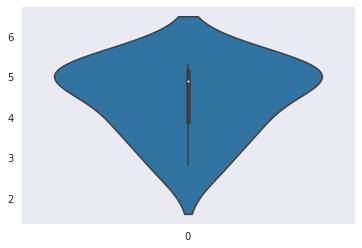

In [45]:
# @title violin plot for distribution analysis
sns.violinplot(data=vectorizer.idf_)

In [36]:
# @title Using bi-grams and tri-grams from query type process and getting the most occured words
vectorizer = TfidfVectorizer(min_df=4,ngram_range=(2,3))
vpro = vectorizer.fit_transform(qtpro)
print(vpro.shape)
fpro = vectorizer.get_feature_names()
fpro

(158, 5)


['how can', 'how do', 'how to', 'in the', 'what is']

In [38]:
# @title Using bi-grams and tri-grams from query type choice and getting the most occured words
vectorizer = TfidfVectorizer(min_df=15,ngram_range=(2,3))
vchc = vectorizer.fit_transform(qtchc)
print(vchc.shape)
fchc = vectorizer.get_feature_names()
fchc

(875, 10)


['can use',
 'how to',
 'in the',
 'is it',
 'is it possible',
 'is the',
 'is there',
 'it possible',
 'it possible to',
 'possible to']

In [37]:
# @title Using bi-grams and tri-grams from query type Entity and getting the most occured words
vectorizer = TfidfVectorizer(min_df=7,ngram_range=(2,3))
vent = vectorizer.fit_transform(qtent)
print(vent.shape)
fent = vectorizer.get_feature_names()
fent

(135, 5)


['is the', 'is the best', 'the best', 'what is', 'what is the']

In [39]:
# @title Using bi-grams and tri-grams from query type comparison and getting the most occured words
vectorizer = TfidfVectorizer(min_df=8,ngram_range=(2,3))
vcmp = vectorizer.fit_transform(qtcmp)
print(vcmp.shape)
fcmp = vectorizer.get_feature_names()
fcmp

(71, 7)


['difference between',
 'is the',
 'is the difference',
 'the difference',
 'the difference between',
 'what is',
 'what is the']

In [40]:
# @title Using bi-grams and tri-grams from query type options and getting the most occured words
vectorizer = TfidfVectorizer(min_df=20,ngram_range=(2,3))
vops = vectorizer.fit_transform(qtops)
print(vops.shape)
fops = vectorizer.get_feature_names()
fops

(1094, 12)


['how can',
 'how do',
 'how to',
 'in the',
 'is it',
 'is the',
 'is the best',
 'the best',
 'way to',
 'what are',
 'what is',
 'what is the']

In [41]:
# @title Using bi-grams and tri-grams from query type definition and getting the most occured words
vectorizer = TfidfVectorizer(min_df=5,ngram_range=(2,3))
vdef = vectorizer.fit_transform(qtdef)
print(vdef.shape)
fdef = vectorizer.get_feature_names()
fdef

(51, 3)


['what does', 'what is', 'what the']

In [42]:
# @title Using bi-grams and tri-grams from query type explanation and getting the most occured words
vectorizer = TfidfVectorizer(min_df=15,ngram_range=(2,3))
vexp = vectorizer.fit_transform(qtexp)
fexp = vectorizer.get_feature_names()
fexp

['are the',
 'does the',
 'how can',
 'how do',
 'how does',
 'in the',
 'is it',
 'is the',
 'of the',
 'the same',
 'what are',
 'what are the',
 'what does',
 'what is',
 'what is the',
 'why are',
 'why did',
 'why do',
 'why does',
 'why is',
 'why is the']

In [43]:
# @title Extracting the pos-tags
%%time
nlp = spacy.load("en_core_web_md")
ptcon = qtcon.apply(lambda x : pos_tag(x))
ptcmp = qtcmp.apply(lambda x : pos_tag(x))
ptchc = qtcmp.apply(lambda x : pos_tag(x))
ptins = qtins.apply(lambda x : pos_tag(x))
ptpro = qtpro.apply(lambda x : pos_tag(x))
ptent = qtent.apply(lambda x : pos_tag(x))
ptops = qtops.apply(lambda x : pos_tag(x))
ptdef = qtdef.apply(lambda x : pos_tag(x))
ptexp = qtexp.apply(lambda x : pos_tag(x))

CPU times: user 39.2 s, sys: 359 ms, total: 39.5 s
Wall time: 39.3 s


In [44]:
#@title Extracting pos-tags from test data
ptest = test_qt.apply(lambda x : pos_tag(x))

In [45]:
# @title Ranking the question category based on the question occurance values
from tqdm import tqdm
(stchc,qschc) = qstart(qtchc)
(stcon,qscon) = qstart(qtcon)
(stins,qsins) = qstart(qtins)
(stpro,qspro) = qstart(qtpro)
(stent,qsent) = qstart(qtent)
(stcmp,qscmp) = qstart(qtcmp)
(stexp,qsexp) = qstart(qtexp)
(stops,qsops) = qstart(qtops)
(stdef,qsdef) = qstart(qtdef)
(sttst,qstst) = qstart(test_qt)

875it [00:00, 174016.88it/s]
11it [00:00, 16165.85it/s]
1985it [00:00, 187769.36it/s]
158it [00:00, 112283.98it/s]
135it [00:00, 120989.54it/s]
71it [00:00, 134932.30it/s]
1171it [00:00, 141192.72it/s]
1094it [00:00, 137152.34it/s]
51it [00:00, 129016.59it/s]
476it [00:00, 186031.37it/s]


In [51]:
qtchc

3        can
14      nonq
17       can
18      nonq
34      nonq
        ... 
6031    nonq
6036    nonq
6037    nonq
6043    nonq
6054    nonq
Name: question_title, Length: 875, dtype: object

In [46]:
# @title Printing the occurance rank values
def pr_key(key):
    print(key)
    print('chc',stchc[key])
    print('con',stcon[key])
    print('def',stdef[key])
    print('ins',stins[key])
    print('pro',stpro[key])
    print('ent',stent[key])
    print('ops',stops[key])
    print('---------------')
    
print(pr_key('what'))
print(pr_key('how'))
print(pr_key('when'))
print(pr_key('why'))
print(pr_key('where'))
print(pr_key('is'))

what
chc 0.022857142857142857
con 0.18181818181818182
def 0.5490196078431373
ins 0.01662468513853904
pro 0.06329113924050633
ent 0.18518518518518517
ops 0.09780621572212066
---------------
None
how
chc 0.021714285714285714
con 0.0
def 0.0
ins 0.18841309823677582
pro 0.189873417721519
ent 0.044444444444444446
ops 0.12157221206581353
---------------
None
when
chc 0.010285714285714285
con 0.0
def 0.0196078431372549
ins 0.0015113350125944584
pro 0.006329113924050633
ent 0.0
ops 0.010968921389396709
---------------
None
why
chc 0.006857142857142857
con 0.09090909090909091
def 0.0
ins 0.0025188916876574307
pro 0.0
ent 0.007407407407407408
ops 0.026508226691042046
---------------
None
where
chc 0.001142857142857143
con 0.0
def 0.0
ins 0.0015113350125944584
pro 0.006329113924050633
ent 0.05185185185185185
ops 0.002742230347349177
---------------
None
is
chc 0.15885714285714286
con 0.0
def 0.0392156862745098
ins 0.015617128463476071
pro 0.02531645569620253
ent 0.05925925925925926
ops 0.06032906

## WORD/ SENTENCE/ DOCUMENT EMBEDDINGS

In [55]:
# Importing the NLP libraries
import flair
from flair.data import Sentence
from flair.embeddings import WordEmbeddings
from flair.embeddings import TransformerWordEmbeddings
from flair.embeddings import StackedEmbeddings
from flair.embeddings import FlairEmbeddings
from flair.embeddings import BertEmbeddings
from flair.embeddings import ELMoEmbeddings
from flair.embeddings import FlairEmbeddings
from flair.embeddings import FastTextEmbeddings

In [62]:
# # @title Using the Flair stacked embeddings
#glove_embedding = WordEmbeddings('glove')
flair_forward  = FlairEmbeddings('news-forward-fast')
flair_backward = FlairEmbeddings('news-backward-fast')
bert_embedding = TransformerWordEmbeddings("roberta-base", layers="all",fine_tune=True)
stacked_embeddings = StackedEmbeddings( embeddings = [ 
                                                        bert_embedding,
                                                        flair_forward , 
                                                        flair_backward,
                                                      ])

In [66]:
from flair.embeddings import DocumentPoolEmbeddings

document_embeddings = DocumentPoolEmbeddings([bert_embedding,])

In [72]:
s1 = Sentence(train_qt.values[0])
s2 = Sentence(train_qb.values[3])
document_embeddings.embed(s1)
document_embeddings.embed(s2)
print(s1.embedding.shape)
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-9)
cos(s1.embedding,s2.embedding)

torch.Size([768])


tensor(0.9603, device='cuda:0')

In [ ]:
from flair.models import MultiTagger

# load tagger for POS and NER 
tagger = MultiTagger.load(['pos', 'ner'])
sentence = Sentence('call Nilesh Chilka and his associates from Solapur who work for Kaglorsys Technologies.')

# run NER over sentence
tagger.predict(sentence)
print(sentence)


In [ ]:
%%time
def st_emb(col,type_of = 'sentence'):
  ''' creates sentence or document embeddings usinf flair'''
  sent = Sentence(col)
  el = []
  if type_of == 'sentence':
    xx = stacked_embeddings.embed(sent)
    for x in sent:
      el.append(x.embedding)
      return el
  elif type_of == 'document':
    xx = document_embeddings.embed(sent)
    for x in sent:
      el.append(x.embedding)
      return el


In [ ]:
train.question_title.values[0]

In [ ]:
%%time
strembqt = train.question_title.map(st_emb)
stsembqt = test.question_title.map(st_emb)

In [ ]:
qry = ['opinion seeking', 'choice',
       'compare', 'consequence',
       'definition', 'entity',
       'instructions', 'procedure']

qry_emb = [st_emb(q) for q in qry]

In [ ]:
%%time
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-9)
print(cos(strembqt.values[1][0],qry_emb[1][0]))


In [ ]:
# @title embedding the title , body and answe features using google universal encoders
import tensorflow as tf
import tensorflow_hub as hub
#google universal encoders https://towardsdatascience.com/use-cases-of-googles-universal-sentence-encoder-in-production-dd5aaab4fc15
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_url = "https://tfhub.dev/google/elmo/2"  
model = hub.load(module_url)
print ("module %s loaded" % model_url)
@tf.function
def embed(input):
    return model(input)

In [ ]:
# @title calculating the tfidf w2v for queries with words from tfidf features
def tf_w2v(txt,tfidf_words):
    tfidf_w2v_vector = [];
    for sent in tqdm(txt):
        vect = np.zeros(300)
        tfidf_weight =0;
        for word in sent.split():
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))#getting tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weight w2v
                tf_idf_weight += tf_idf
    if tfidf_weight !=0:
        vector /= tfidf_weight
    tfidf_w2v_vector.append(vector)
    return tfidf_w2v_vector

In [ ]:
# @title embedding the text features using google universal encoders
#https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb#scrollTo=Q8F4LNGFqOiq
opsbd_emb = tf.make_ndarray(tf.make_tensor_proto(embed(qbops)))
conbd_emb = tf.make_ndarray(tf.make_tensor_proto(embed(qbcon)))
chcbd_emb = tf.make_ndarray(tf.make_tensor_proto(embed(qbchc)))
defbd_emb = tf.make_ndarray(tf.make_tensor_proto(embed(qbdef)))
insbd_emb = tf.make_ndarray(tf.make_tensor_proto(embed(qbins)))
expbd_emb = tf.make_ndarray(tf.make_tensor_proto(embed(qbexp)))
entbd_emb = tf.make_ndarray(tf.make_tensor_proto(embed(qbent)))
cmpbd_emb = tf.make_ndarray(tf.make_tensor_proto(embed(qbcmp)))
probd_emb = tf.make_ndarray(tf.make_tensor_proto(embed(qbpro)))
aops_emb = tf.make_ndarray(tf.make_tensor_proto(embed(aops)))
acon_emb = tf.make_ndarray(tf.make_tensor_proto(embed(acon)))
achc_emb = tf.make_ndarray(tf.make_tensor_proto(embed(achc)))
adef_emb = tf.make_ndarray(tf.make_tensor_proto(embed(adef)))
ains_emb = tf.make_ndarray(tf.make_tensor_proto(embed(ains)))
aexp_emb = tf.make_ndarray(tf.make_tensor_proto(embed(aexp)))
aent_emb = tf.make_ndarray(tf.make_tensor_proto(embed(aent)))
acmp_emb = tf.make_ndarray(tf.make_tensor_proto(embed(acmp)))
apro_emb = tf.make_ndarray(tf.make_tensor_proto(embed(apro)))
test_qt_emb = tf.make_ndarray(tf.make_tensor_proto(embed(test_qt)))
test_qb_emb = tf.make_ndarray(tf.make_tensor_proto(embed(test_qb)))
test_ans_emb = tf.make_ndarray(tf.make_tensor_proto(embed(test_ans)))

In [ ]:
tmp = tf.make_ndarray(tf.make_tensor_proto(embed(train_qt)))
qr_emb = tf.make_ndarray(tf.make_tensor_proto(embed(pd.Series(qry))))


In [ ]:
from sklearn.metrics import *
set(train.columns)-set(test.columns)

In [ ]:
import scipy
scipy.stats.spearmanr(opsbd_emb[1],aops_emb[1])

In [ ]:
# @title combining all the embeddings into respective categories
import numpy as np
opsdata = np.hstack((opsbd_emb,aops_emb))
chcdata = np.hstack((chcbd_emb,achc_emb))
insdata = np.hstack((insbd_emb,ains_emb))
entdata = np.hstack((entbd_emb,aent_emb))
expdata = np.hstack((expbd_emb,aexp_emb))
prodata = np.hstack((probd_emb,apro_emb))
condata = np.hstack((conbd_emb,acon_emb))
defdata = np.hstack((defbd_emb,adef_emb))
cmpdata = np.hstack((cmpbd_emb,acmp_emb))
testdata = np.hstack((test_qb_emb,test_ans_emb))

In [ ]:
# @title Plotting the text similarities
# Code borrowed from google universal encoder similarity colab notebook
@tf.function
def plot_similarity(labels, features, rotation):
    corr = scipy.stats.spearmanr(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)

In [ ]:
# @title pos-tag similarities and sequence matching
!pip install -q edit_distance
from statistics import mean
import edit_distance
# mutual pos similarity
def mpos_sim(pt):
    mt=[]
    for i in range(len(pt)):
        for j in range(len(pt)):
            if (i!=j):
                while j==len(pt)-1:
                    sm = edit_distance.SequenceMatcher(a=pt.values[i],b=pt.values[j])
                    cnt = cnt
                mt.append(sm.matches()/max([len(pt.values[i]),len(pt.values[j])]))
    return mt


#pos sequence
def pos_seq(pt1,pt2):
    mt = []
    pt = min([len(pt1),len(pt2)])
    for i in range(pt):
        sm = edit_distance.SequenceMatcher(a=pt1.values[i],b=pt2.values[i])
        lp = sm.matches() / max([len(pt1.values[i]),len(pt2.values[i])])
        mt.append(lp)
    return mean(mt)

In [ ]:
edit_distance.edit_distance('what is your name','who are you')

In [ ]:
# @title spearman similarity
@tf.function
def spearman(y_true, y_pred):
     return ( tf.py_function(scipy.stats.spearmanr, [tf.cast(y_pred, tf.float32), 
                       tf.cast(y_true, tf.float32)], Tout = tf.float32) )


In [ ]:
# @title Embedding similarity
def sim(a,b):
    c = []
    for i in range(len(a)):
        c.append(np.inner(a[i],b[i]))
    return np.array(c)


In [ ]:
# @title getting similarities
# similarities between question body and answer
basops = sim(opsbd_emb,aops_emb)
baschc = sim(chcbd_emb,achc_emb)
bascmp = sim(cmpbd_emb,acmp_emb)
basdef = sim(defbd_emb,adef_emb)
basins = sim(insbd_emb,ains_emb)
basent = sim(entbd_emb,aent_emb)
basexp = sim(expbd_emb,aexp_emb)
baspro = sim(probd_emb,apro_emb)
bascon = sim(conbd_emb,acon_emb)
bastst = sim(test_qb_emb,test_ans_emb)


In [ ]:
def stack_features(args):
  if type(args[1])


In [ ]:
# @title sentiment analysis for matching question answer sentiment
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def sent_score(col):
    '''Calculating sentiment scores of the text data'''
    neg,neu= [],[]
    pos,comp = [],[]
    sid = SentimentIntensityAnalyzer()
    for txt in tqdm(col):
        sps = sid.polarity_scores(txt)
        neg.append(sps['neg'])
        neu.append(sps['neu'])
        pos.append(sps['pos'])
        comp.append(sps['compound'])
        dtp = {'neg':neg,'neu':neu,'pos':pos,'compound':comp}
    return pd.DataFrame(dtp)
    

In [ ]:
# @title sentiment scores for train answers
nltk.download('vader_lexicon')
sentcon = sent_score(acon)
sentchc = sent_score(achc)
sentdef = sent_score(adef)
sentins = sent_score(ains)
sentpro = sent_score(apro)
sentexp = sent_score(aexp)
sentent = sent_score(aent)
sentcmp = sent_score(acmp)
sentops = sent_score(aops)

In [ ]:
# @title sentiment scores for tes data
senttest = sent_score(test_ans)

In [ ]:
# @title count of words in the text
def cnt(qn):
    '''counts the number of words in text'''
    qn = qn.strip()
    return len(qn)


In [ ]:
# @title word count of question data
from sklearn.preprocessing import StandardScaler,Normalizer
nz = Normalizer()
def scale(cnt):
    cnt = np.array(cnt).reshape(-1,1)
    cnt = nz.fit_transform(cnt)
    cnt = cnt.reshape(-1,1)
    return cnt


cntqchc = qbchc.apply(lambda x : scale(cnt(x)))
cntqcon = qbcon.apply(lambda x : scale(cnt(x)))
cntqcmp = qbcmp.apply(lambda x : scale(cnt(x)))
cntqpro = qbpro.apply(lambda x : scale(cnt(x)))
cntqdef = qbdef.apply(lambda x : scale(cnt(x)))
cntqins = qbins.apply(lambda x : scale(cnt(x)))
cntqexp = qbexp.apply(lambda x : scale(cnt(x)))
cntqops = qbops.apply(lambda x : scale(cnt(x)))
cntqent = qbent.apply(lambda x : scale(cnt(x)))

#word count of answer data
cntachc = achc.apply(lambda x : scale(cnt(x)))
cntacon = acon.apply(lambda x : scale(cnt(x)))
cntacmp = acmp.apply(lambda x : scale(cnt(x)))
cntapro = apro.apply(lambda x : scale(cnt(x)))
cntadef = adef.apply(lambda x : scale(cnt(x)))
cntains = ains.apply(lambda x : scale(cnt(x)))
cntaexp = aexp.apply(lambda x : scale(cnt(x)))
cntaops = aops.apply(lambda x : scale(cnt(x)))
cntaent = aent.apply(lambda x : scale(cnt(x)))

#word count of test qestion body and answer data
cntqbtest = test_qb.apply(lambda x : scale(cnt(x)))
cntanstest = test_ans.apply(lambda x : scale(cnt(x)))

In [ ]:
# @title Response coding for categorical variables
def res_code(df,catcol,na,nb):
    # catcol : categorical feature column name
    # na : name of the positive class after response coding
    # nb : name of the negative class after response coding
    data = df[catcol]
    a = dict(data.value_counts()) # total count of categorical variable
    b = data.get_values() # total variables
    c = pd.DataFrame({'cat':b,'y':Y_train}) # creating dataframe with cat variables and class response 
    c_1 = dict(c.cat[c['y']==1].value_counts()) # tking positive class variables
    k = [key for key in b if key not in c_1] # if certain key has count 1 in total and is not in positive class 
    c_k = {x:0*i for i,x in enumerate(k) if len(k)!=0} # assigning the unfound category in the class with value 0
    c_1.update(c_k) # updating the positive class response variable
    d1 = np.array([float(c_1[key]/a[key]) for key in b ]) # finding the ressponse encode by findinf occurance ratio
    d0 = 1 - d1; # occurance ratio for negative class as (p'=1-p)
    t = []
    k1 = {key : float(c_1[key]/a[key]) for key in b if key not in t}
    k2 = {k:1-v for k,v in k1.items()}
    dat = X_test[catcol]
    b1 = dat.get_values()
    a1 = {n:0.5 for n in b1 if n not in b}
    k1.update(a1)
    k2.update(a1)
    t1 = dat.replace(k1)
    t2 = dat.replace(k2)
    return (pd.DataFrame({na:d1,nb:d0}),pd.DataFrame({na:t1,nb:t2}))


In [ ]:
# @title Label-Encoding keywords
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
catcon = enc.fit_transform(qscon.values.reshape(-1,1))
catchc = enc.fit_transform(qschc.values.reshape(-1,1))
catcmp = enc.fit_transform(qscmp.values.reshape(-1,1))
catins = enc.fit_transform(qsins.values.reshape(-1,1))
catpro = enc.fit_transform(qspro.values.reshape(-1,1))
catdef = enc.fit_transform(qsdef.values.reshape(-1,1))
catent = enc.fit_transform(qsent.values.reshape(-1,1))
catexp = enc.fit_transform(qsexp.values.reshape(-1,1))
catops = enc.fit_transform(qsops.values.reshape(-1,1))

In [ ]:
qscon

In [ ]:
# @title function for hyper parameter tuning
from sklearn.model_selection import GridSearchCV
def tune(model,params,X_train,Y_train):
    '''Performing hyperparameter tuning and predicting using best estimators'''
    clf = GridSearchCV(model, parameters,return_train_score=True,n_jobs=-1)
    clf.fit(x_train,Y_train)
    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    #https://plot.ly/python/3d-scatter-plots/
    print(clf.best_estimator_)
    

In [ ]:
def train_m(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [ ]:
#@title MULTILABEL CLASSIFICATION USING XLNET https://colab.research.google.com/drive/1o3cv-YSPGiKftCvFnCiMcygARqdaxrM7#scrollTo=o4ZY1PcIlfKW
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=11):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    


In [ ]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

In [ ]:
model = XLNetForMultiLabelSequenceClassification(num_labels=31)
model = torch.nn.DataParallel(model)
model.cuda()

In [ ]:
from transformers import *
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=125):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-uncased', do_lower_case=True)
tr_title_tok = tokenize_inputs(train_qt, tokenizer, num_embeddings=150)
ts_title_tok = tokenize_inputs(test_qt,tokenizer,num_embeddings=150)

In [ ]:
from sentence_transformers import SentenceTransformer
model_b = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')

In [ ]:
bercon = model_b.encode(nqcon)
berchc = model_b.encode(nqchc)
berins = model_b.encode(nqins)
bercmp = model_b.encode(nqcmp)
berpro = model_b.encode(nqpro)
berdef = model_b.encode(nqdef)
berexp = model_b.encode(nqexp)
berent = model_b.encode(nqent)
bertr = model_b.encode(cvr(train_qt))
bertst = model_b.encode(nqtst)

In [ ]:
bertrans = model_b.encode(train_ans,num_workers=2)
bertsans = model_b.encode(test_ans,num_workers=2)

In [ ]:
train_dataloader = torch.tensor(bertr)
dev_dataloader =  torch.tensor(bertst)

In [ ]:
ldef stack_features(features):
  ''' converting distributed features into single feature '''
  
  

In [ ]:
# new embeddings 

In [ ]:
def emb_map(word,context,category,tense,pos,associate,map,embed):
  word :{'context':['require','need'], # representing words with meaning from dictionary
          'category': int(), # class or cluster number
          'Tense' : 'PT', # PT,PR,FT
          'POS': 'VBD', # NOUN,PRON,ADJ,ADV,VB[G,D,P],PREP
          'associate': '', # adj for nn,adv for vb
          'mapping': '', # whether sub/obj
          'embed' : [], # embedding based on sentence mapping
          }

In [ ]:
def ent_skeleton(name,**kwargs):

In [ ]:
q = 'can you adjust the room temperature for me'
R = 'can I adjust the room temperature for him(Bharat)'
i = 'adjust(room temperature)'
S = 'room_temperature (entity)~(preference_quantity=25^C)'
o = 'done ! set to %d temperature'
param = 'outside_temp|room_temp|ac|control|entering home|Bharat'
proc1 = remember(i,S,time,situation,param)
assign_task(proc1,rep='daily')

In [ ]:
class Process:
  def remember_params(intent,setting,output,*params):
    '''remembering the summary of the task and the situation'''
    # append to person database

  